In [1]:
import sys
sys.path.append('/notebooks/MOD2NN')

In [3]:
import os
import json
import glob
import re

from scipy import stats
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

from CNN.module.lib.layers import *
from Faraday.two_dim.module.lib.layers import *

from Faraday.two_dim import matplotlib_style
matplotlib_style.paper()

tf.random.set_seed(1)

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

TensorFlow: 2.9.1
Python: 3.9.13 (main, May 23 2022, 22:01:06) 
[GCC 9.4.0]
TensorFlow: 2.9.1
Python: 3.9.13 (main, May 23 2022, 22:01:06) 
[GCC 9.4.0]


In [4]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.sqrt(x_train.astype("float32") / 255.0)
x_test = np.sqrt(x_test.astype("float32") / 255.0)

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

11490434/11490434 [==============================] - 0s 0us/step


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


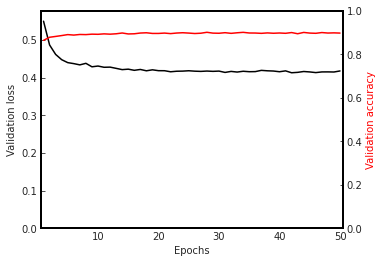

In [5]:
path = "trained_model/20230119/angle"

matplotlib_style.paper()
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["mathtext.fontset"] = "cm"

fig = plt.figure()
ax1 = fig.add_subplot()
ax2 = ax1.twinx()

df = pd.read_csv(path + "/history.csv")
epochs = np.arange(len(df["val_loss"])) + 1
ax1.plot(epochs, df["val_loss"], color="black")
ax2.plot(epochs, df["val_accuracy"], color="red")


ax1.set_xlabel("Epochs")
ax1.set_ylabel("Validation loss")
ax1.set_ylim(0, max(df["val_loss"])*1.05)

ax2.set_ylabel("Validation accuracy")
ax2.set_ylim(0,1)
ax2.yaxis.label.set_color('red')
plt.savefig("images/paper/5bimoayer_result.png", bbox_inches='tight', dpi=300)

In [6]:
model = tf.keras.models.load_model(path)
eval = model.evaluate(x_test, y_test)
eval

313/313 [==============================] - 6s 15ms/step - loss: 0.4776 - accuracy: 0.8758


[0.4775571823120117, 0.8758000135421753]

In [6]:
pattern = r'binarized_mo'

mo_layers = []
bi_weights = []
error_weights = []

for layer in model.layers:
  result = re.match(pattern, layer.name)
  if result:
      mo_layers.append(layer)
      w = layer.get_weights()
      bi_w = np.where(w[0]>0, 1, -1)
      bi_weights.append(bi_w)

bi_weights

[array([[-1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1, -1, ...,  1,  1,  1],
        ...,
        [ 1,  1,  1, ..., -1, -1,  1],
        [ 1,  1,  1, ..., -1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1]]),
 array([[-1, -1, -1, ...,  1, -1, -1],
        [-1, -1,  1, ...,  1, -1, -1],
        [-1,  1,  1, ...,  1,  1, -1],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [ 1, -1, -1, ..., -1, -1, -1]]),
 array([[ 1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ...,  1,  1,  1],
        [-1, -1, -1, ...,  1,  1,  1],
        ...,
        [ 1, -1, -1, ...,  1,  1,  1],
        [ 1,  1, -1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1, -1]]),
 array([[ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1, -1, ..., -1,  1,  1],
        [ 1, -1, -1, ..., -1, -1,  1],
        ...,
        [ 1,  1, -1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1, -1],
        [ 1,  1,  1, ...,  1, -1, -1]]),
 arr

In [14]:
seeds = np.arange(1, 11)
p = np.arange(0, 1.1, 0.1)
acc_table = np.zeros((len(seeds), len(p)))
loss_table = np.zeros((len(seeds), len(p)))

for j, _p in enumerate(p):
  for k, seed in enumerate(seeds):
    for i, layer in enumerate(mo_layers):
        np.random.seed(seed)
        bi_dist = stats.bernoulli.rvs(p=_p, size=(100,100)) * 2 - 1
        w = layer.get_weights()
        w[0] = bi_weights[i] * bi_dist
        layer.set_weights(w)

    bi_eval = model.evaluate(x_test, y_test)
    acc_table[k, j] = bi_eval[1]
    loss_table[k, j] = bi_eval[0]

313/313 [==============================] - 8s 24ms/step - loss: 0.4776 - accuracy: 0.8758


In [15]:
acc_df = pd.DataFrame(acc_table, columns=["{:.1f}".format(t) for t in p])
loss_df = pd.DataFrame(loss_table, columns=["{:.1f}".format(t)  for t in p])

In [16]:
acc_df.to_csv("out/paper/8/inverse_acc.csv")
loss_df.to_csv("out/paper/8/inverse_loss.csv")

In [11]:
seeds = np.arange(1, 11)
p = np.arange(0, 1.1, 0.1)
acc_table = np.zeros((len(seeds), len(p)))
loss_table = np.zeros((len(seeds), len(p)))

for j, _p in enumerate(p):
  for k, seed in enumerate(seeds):
    for i, layer in enumerate(mo_layers):
        np.random.seed(seed)
        bi_dist = stats.bernoulli.rvs(p=_p, size=(100,100))
        w = layer.get_weights()
        w[0] = bi_weights[i] * bi_dist
        layer.set_weights(w)

    bi_eval = model.evaluate(x_test, y_test)
    acc_table[k, j] = bi_eval[1]
    loss_table[k, j] = bi_eval[0]

313/313 [==============================] - 8s 24ms/step - loss: 0.4776 - accuracy: 0.8758


In [12]:
acc_df = pd.DataFrame(acc_table, columns=["{:.1f}".format(t) for t in p])
loss_df = pd.DataFrame(loss_table, columns=["{:.1f}".format(t)  for t in p])

In [13]:
acc_df.to_csv("out/paper/8/demag_acc.csv")
loss_df.to_csv("out/paper/8/demag_loss.csv")

/tmp/ipykernel_32/1254426527.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpo" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig("out/paper/8/pattern" + str(i) + "_v2.png", dpo=300)


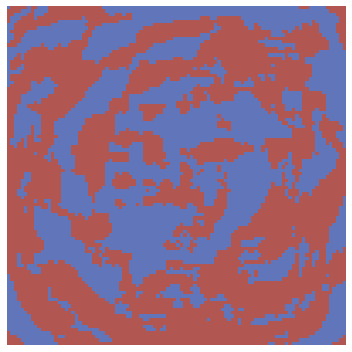

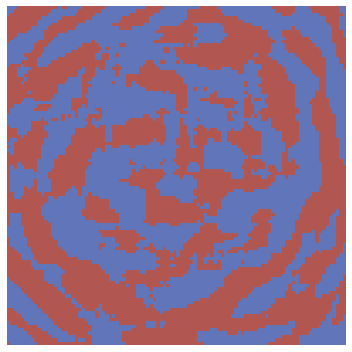

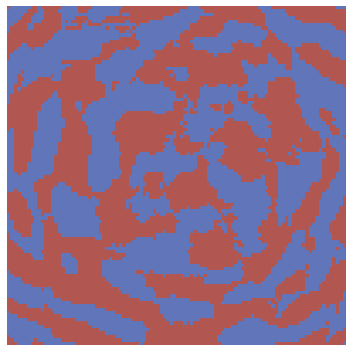

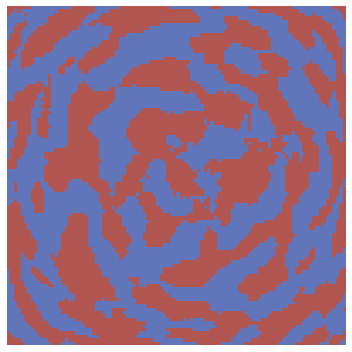

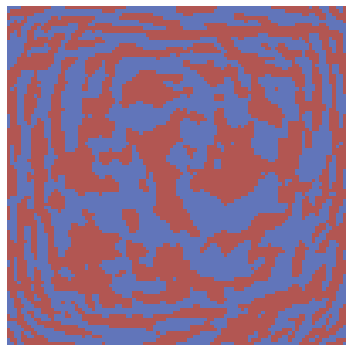

In [48]:
from matplotlib.colors import ListedColormap

colors = ["#D8D4E5", "#EEBBC3"]
cmap = ListedColormap(colors, name="custom")

for i in range(5):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    ax.imshow(bi_weights[i], cmap="twilight_shifted", vmax=2, vmin=-2)
    ax.axis(False)
    fig.tight_layout()
    fig.savefig("out/paper/8/pattern" + str(i) + "_v2.png", dpo=300)

/tmp/ipykernel_32/1769805292.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpo" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("out/paper/8/cmap3.png", dpo=300)


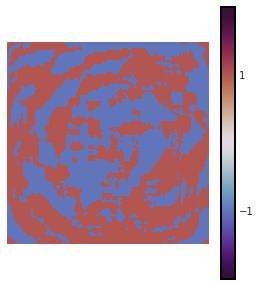

In [45]:
plt.figure(figsize=(5,5))
plt.imshow(bi_weights[0], cmap="twilight_shifted", vmax=2, vmin=-2)
plt.axis(False)
cbar = plt.colorbar()
cbar.set_ticks([-1,1])
plt.savefig("out/paper/8/cmap3.png", dpo=300)

In [ ]:
pattern = r'binarized_mo'

mo_layers = []
bi_weights = []
error_weights = []

for layer in model.layers:
  result = re.match(pattern, layer.name)
  if result:
      mo_layers.append(layer)
      w = layer.get_weights()
      bi_w = np.where(w[0]>0, 1, -1)
      bi_weights.append(bi_w)

bi_weights

In [13]:
seed=1
p = [1,0.9, 0.8,0.7, 0.6, 0.4, 0.2, 0]
outputs = np.zeros((len(p), 10))

for j, _p in enumerate(p):
    for i, layer in enumerate(mo_layers):
        np.random.seed(seed)
        bi_dist = stats.bernoulli.rvs(p=_p, size=(100,100)) * 2 - 1
        w = layer.get_weights()
        w[0] = bi_weights[i] * bi_dist
        layer.set_weights(w)

    pred = model.predict(x_test[0:1,:,:])
    outputs[j,:] = pred[0,:]

1/1 [==============================] - 0s 28ms/step


<BarContainer object of 10 artists>

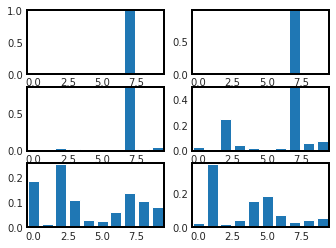

In [14]:
fig, axes = plt.subplots(3,2)

x = np.arange(10)
axes[0,0].bar(x, outputs[0,:])
axes[0,1].bar(x, outputs[1,:])
axes[1,0].bar(x, outputs[2,:])
axes[1,1].bar(x, outputs[3,:])
axes[2,0].bar(x, outputs[4,:])
axes[2,1].bar(x, outputs[5,:])

# 消磁混同行列

In [89]:
seeds = np.arange(1, 11)
p = np.arange(0, 1.1, 0.1)
data = np.zeros((len(p), len(seeds), 10, 10))
data.shape

for seed in seeds:
    for j, _p in enumerate(p):
        for i, layer in enumerate(mo_layers):
            np.random.seed(seed)
            bi_dist = stats.bernoulli.rvs(p=_p, size=(100,100))
            w = layer.get_weights()
            w[0] = bi_weights[i] * bi_dist
            layer.set_weights(w)

        pred_label = tf.argmax(model.predict(x_test), axis=-1).numpy()
        cm = tf.math.confusion_matrix(y_test, pred_label)
        label_tot = np.sum(cm, axis=1).reshape(-1, 1)
        norm_cm = cm/label_tot
        data[j, seed-1, :,:] = norm_cm.numpy()

313/313 [==============================] - 4s 14ms/step


In [90]:
ave_cm = np.average(data, axis=1)
std_cm = np.std(data, axis=1)

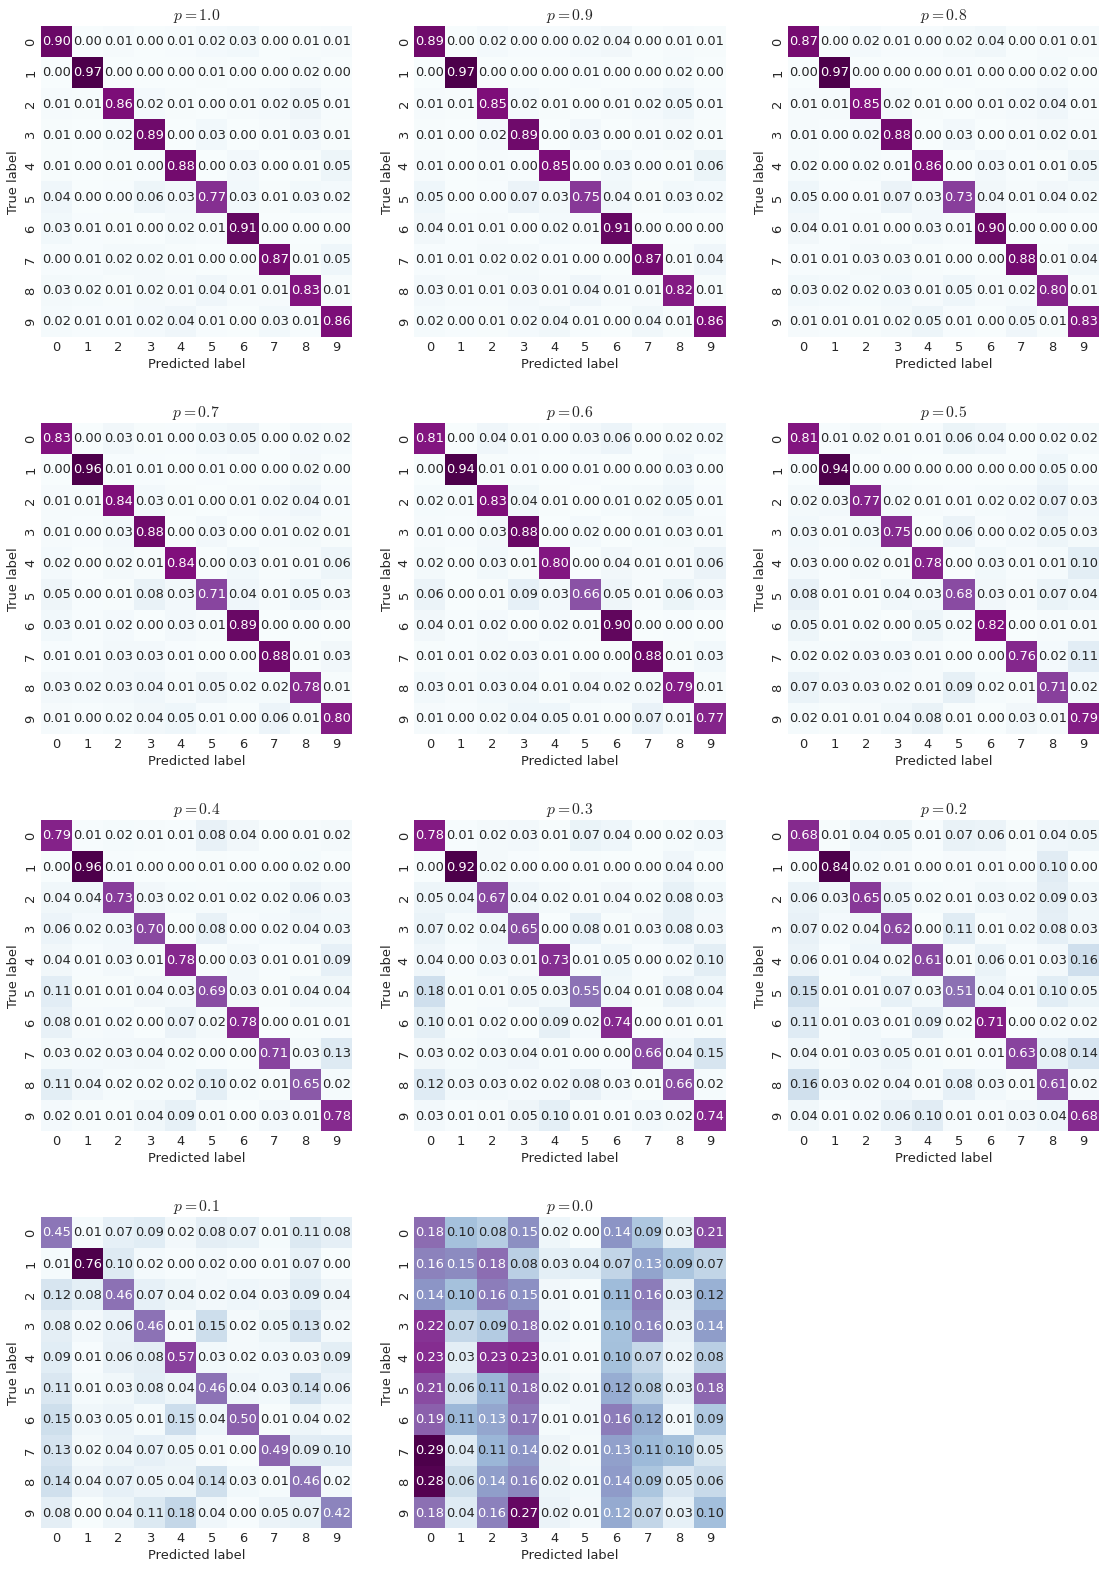

In [91]:
plt.rcParams["font.size"] = 13

fig, axes = plt.subplots(4,3, figsize=(21,28))
count = 10
for _ax in axes:
    for ax in _ax:
        sns.heatmap(ave_cm[count,:,:], square=True, cbar=False, annot=True, fmt=".2f", cmap='BuPu', ax=ax)
        ax.set_xlabel("Predicted label")
        ax.set_ylabel("True label")
        ax.set_title("$p={:.1f}$".format(p[count]))
        count-=1

fig.delaxes(axes[3, 2])
fig.savefig("out/paper/9/cm_ave.png", dpi=300)

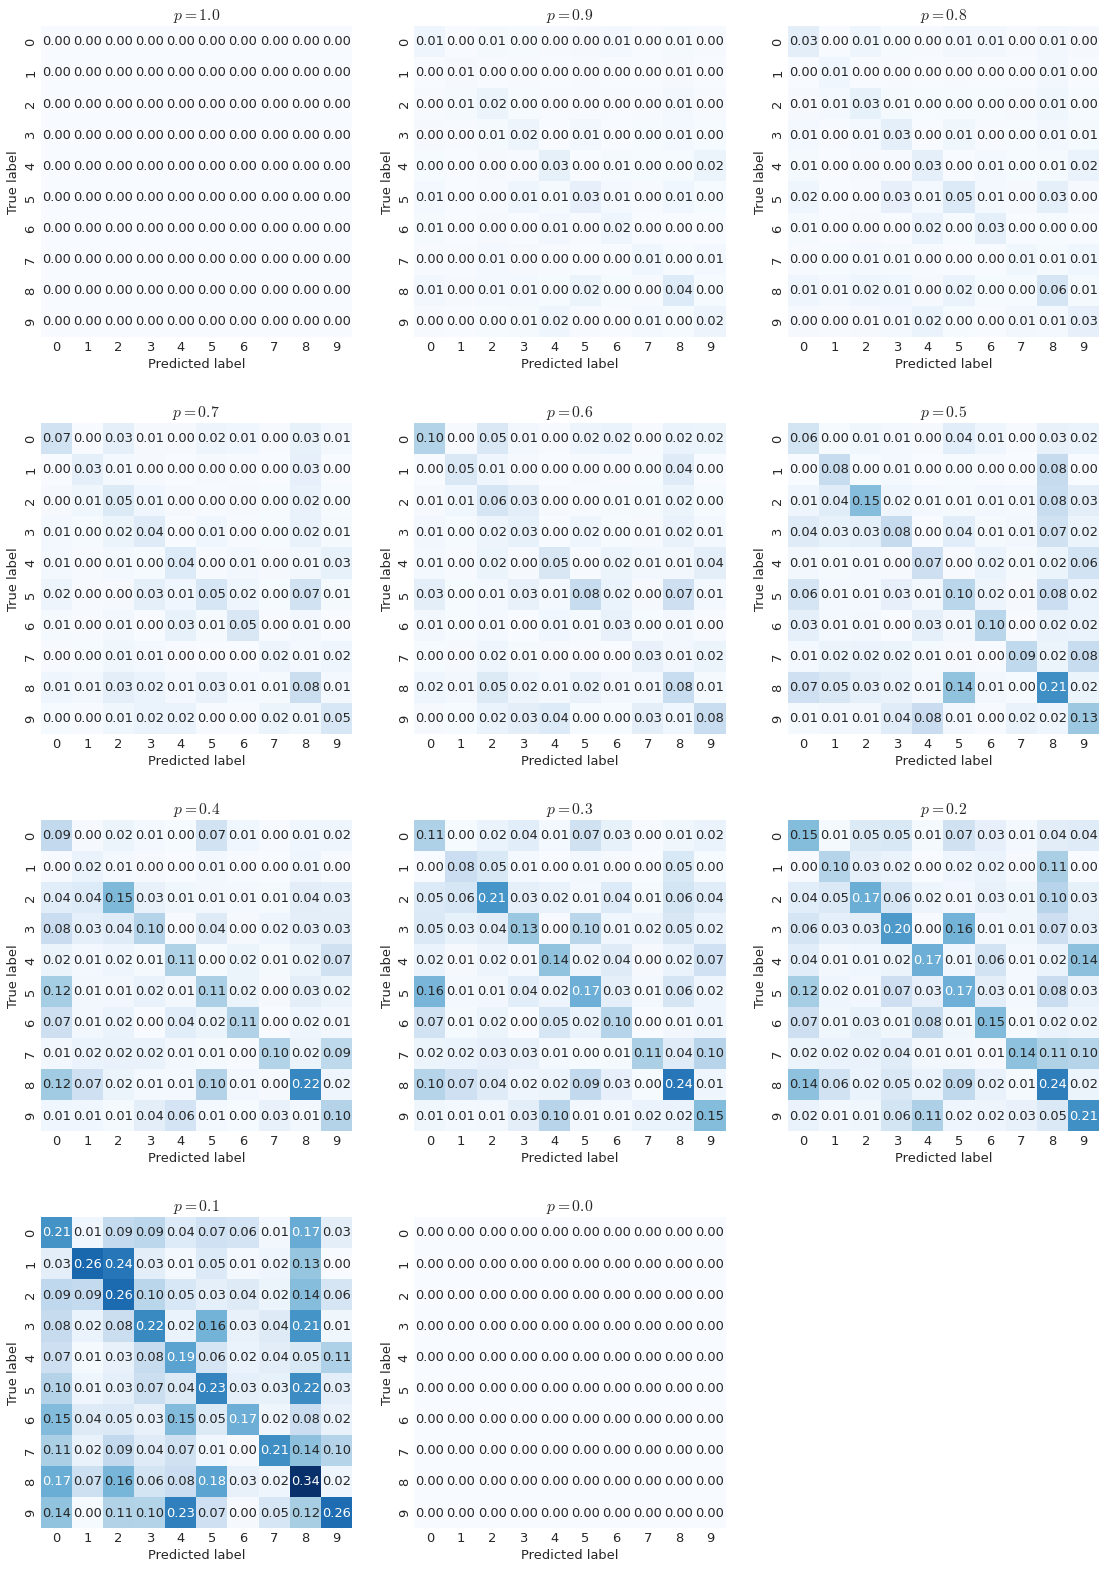

In [92]:
plt.rcParams["font.size"] = 13

fig, axes = plt.subplots(4,3, figsize=(21,28))
count = 10
for _ax in axes:
    for ax in _ax:
        sns.heatmap(std_cm[count,:,:], square=True, cbar=False, annot=True, fmt=".2f", cmap='Blues', ax=ax, vmin=0, vmax=np.max(std_cm))
        ax.set_xlabel("Predicted label")
        ax.set_ylabel("True label")
        ax.set_title("$p={:.1f}$".format(p[count]))
        count-=1

fig.delaxes(axes[3, 2])
fig.savefig("out/paper/9/cm_std.png", dpi=300)

# 反転公道行列

In [104]:
seeds = np.arange(1, 11)
p = np.arange(0, 1.1, 0.1)
data = np.zeros((len(p), len(seeds), 10, 10))
data.shape

for seed in seeds:
    for j, _p in enumerate(p):
        for i, layer in enumerate(mo_layers):
            np.random.seed(seed)
            bi_dist = stats.bernoulli.rvs(p=_p, size=(100,100)) * 2 - 1
            w = layer.get_weights()
            w[0] = bi_weights[i] * bi_dist
            layer.set_weights(w)

        pred_label = tf.argmax(model.predict(x_test), axis=-1).numpy()
        cm = tf.math.confusion_matrix(y_test, pred_label)
        label_tot = np.sum(cm, axis=1).reshape(-1, 1)
        norm_cm = cm/label_tot
        data[j, seed-1, :,:] = norm_cm.numpy()

313/313 [==============================] - 5s 14ms/step


In [105]:
ave_cm = np.average(data, axis=1)
std_cm = np.std(data, axis=1)

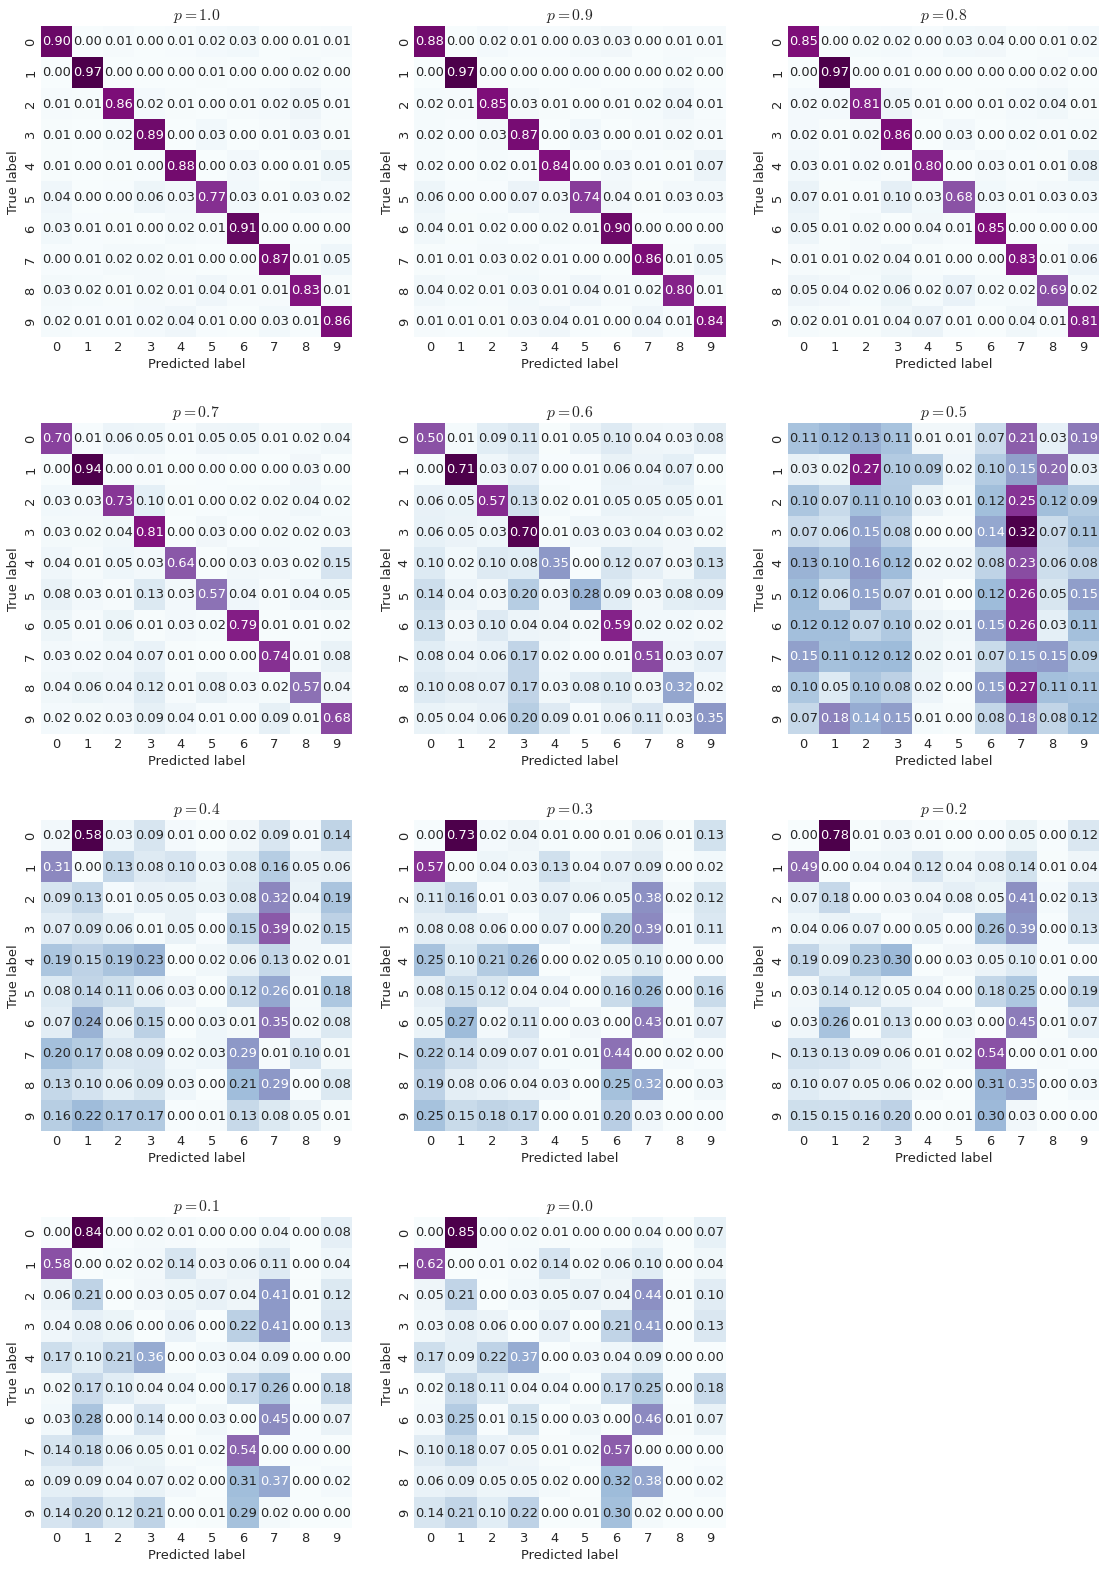

In [106]:
plt.rcParams["font.size"] = 13

fig, axes = plt.subplots(4,3, figsize=(21,28))
count = 10
for _ax in axes:
    for ax in _ax:
        sns.heatmap(ave_cm[count,:,:], square=True, cbar=False, annot=True, fmt=".2f", cmap='BuPu', ax=ax)
        ax.set_xlabel("Predicted label")
        ax.set_ylabel("True label")
        ax.set_title("$p={:.1f}$".format(p[count]))
        count-=1

fig.delaxes(axes[3, 2])
fig.savefig("out/paper/9/cm_ave_inv.png", dpi=300)

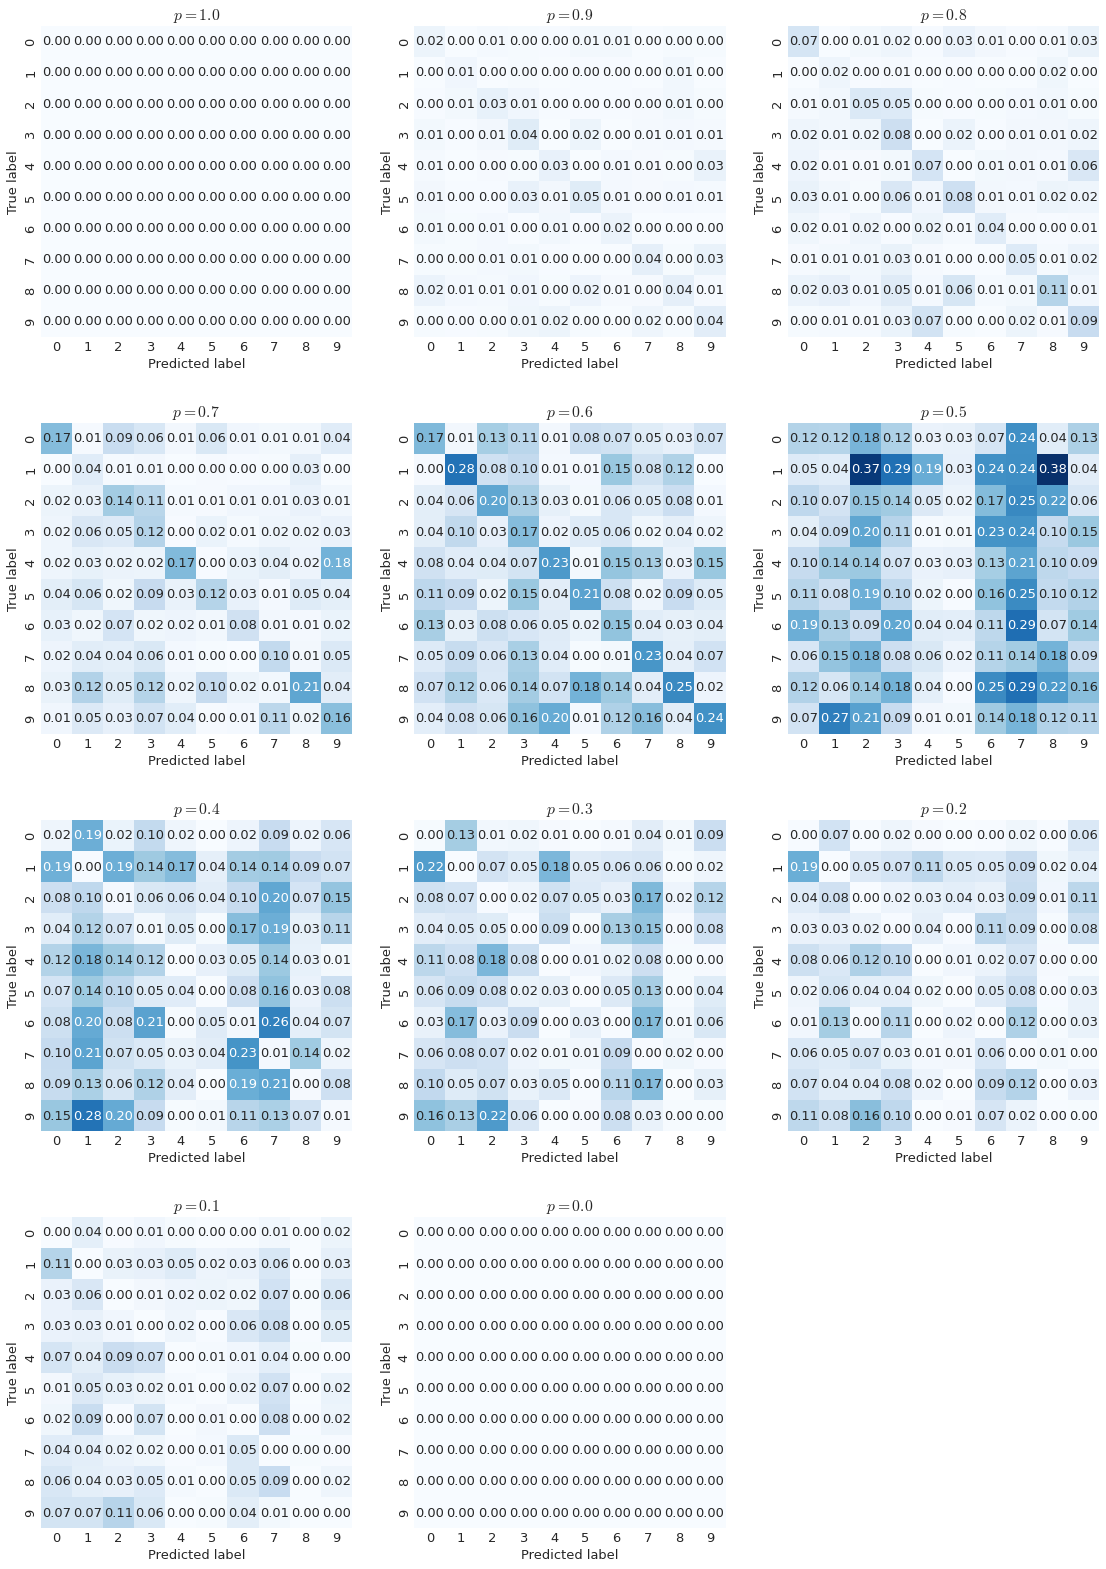

In [107]:
plt.rcParams["font.size"] = 13

fig, axes = plt.subplots(4,3, figsize=(21,28))
count = 10
for _ax in axes:
    for ax in _ax:
        sns.heatmap(std_cm[count,:,:], square=True, cbar=False, annot=True, fmt=".2f", cmap='Blues', ax=ax, vmin=0, vmax=np.max(std_cm))
        ax.set_xlabel("Predicted label")
        ax.set_ylabel("True label")
        ax.set_title("$p={:.1f}$".format(p[count]))
        count-=1

fig.delaxes(axes[3, 2])
fig.savefig("out/paper/9/cm_std_inv.png", dpi=300)